# 卷积网络
到目前为止，我们已经使用深度全连接网络，使用它们来探索不同的优化策略和网络架构。全连接网络是一个很好的实验平台，因为它们的计算效率非常高，但实际上，所有最先进的结果都使用了卷积网络。
首先，您将实现几个在卷积网络中使用的层类型。然后，您将使用这些层在CIFAR-10数据集上训练卷积网络。

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# 卷积:简单的前向传递
卷积网络的核心是卷积运算。在文件`cs231n/layers`中。在函数`conv_forward_naive`中实现卷积层的前向传递。
在这一点上你不必太担心效率;只要用你认为最清楚的方式来写代码。
你可以通过运行以下程序来测试你的实现:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Aside:通过卷积进行图像处理
我们将设置一个包含两个图像的输入，并手动设置过滤器来执行常见的图像处理操作(灰度转换和边缘检测)，这是一种既可以检查实现又可以更好地了解卷积层可以执行的操作类型的有趣方法。卷积前向传递将对每个输入图像应用这些操作。然后，我们可以将结果可视化为一个完整性检查。

D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
D:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


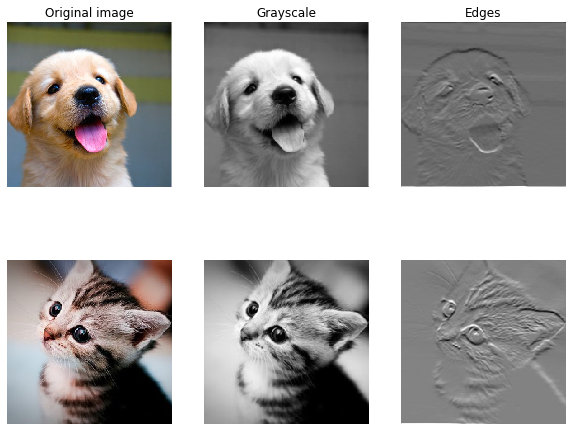

In [4]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# 卷积:简单的后向传递
在文件`cs231n/layers.py`中的函数`conv_backward_naive`中实现卷积操作的向后传递。同样，你不需要太担心计算效率。
完成后，运行以下命令，用数值梯度检查检查后向遍历。

In [8]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.247109434939654e-10
db error:  3.37264006649648e-11


# 最大池化:简单的前向
在文件`cs231n/layers.py`中的函数`max_pool_forward_naive`中实现max-pooling操作的前向传递。同样，不要太担心计算效率。
检查你的实现运行以下:

In [10]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# 最大池化:简单后向传递
在文件`cs231n/layers.py`中的函数`max_pool_backward_naive`中实现最大池操作的向后传递。你不需要担心计算效率。
检查你的实现与数值梯度检查运行以下:

In [12]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# 快速层
快速实现卷积和池化层具有挑战性。为了避免麻烦，我们在文件`cs231n/fast_layers.py`中为卷积和池化层提供了向前和向后传递的快速实现。
快速卷积的实现依赖于一个Cython扩展;要编译它，你需要运行以下`cs231n `目录:

```bash
python setup.py build_ext --inplace
```
卷积和池化层的快速版本的API与上面实现的原始版本完全相同:前向传递接收数据、权重和参数，并产生输出和缓存对象;后向传递接收上游导数和缓存对象，并产生与数据和权重相关的梯度。

**注:** 池的快速实现只有在池区域不重叠和平铺输入时才会优化执行。如果不满足这些条件，那么快速池实现不会比简单实现快很多。

你可以比较这些层的性能简单和快速版本运行以下:

In [13]:
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 0.200464s
Fast: 0.019946s
Speedup: 10.050167x
Difference:  4.926407851494105e-11

Testing conv_backward_fast:
Naive: 0.914554s
Fast: 0.016954s
Speedup: 53.941923x
dx difference:  1.006330206620509e-11
dw difference:  2.497142522392147e-13
db difference:  0.0


In [14]:
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.010943s
fast: 0.005981s
speedup: 1.829513x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.022975s
speedup: 1.441425x
dx difference:  0.0


# 卷积的“三明治”层
前面我们介绍了“三明治”层的概念，它将多个操作组合成常用的模式。在文件`cs231n/layer_utils`中。你会发现三明治层实现了一些常用的卷积网络模式。

In [15]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  5.828178746516271e-09
dw error:  8.443628091870788e-09
db error:  3.57960501324485e-10


In [18]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  3.5600610115232832e-09
dw error:  2.2497700915729298e-10
db error:  1.3087619975802167e-10


# 三层卷积网络
现在您已经实现了所有必要的层，我们可以将它们放到一个简单的卷积网络中。
打开文件`cs231n/classifiers/cnn`。完成`ThreeLayerConvNet`类的实现。运行以下单元来帮助您调试:

检查损失
在你建立一个新的网络之后，你应该做的第一件事就是检查损失。当我们使用softmax损失时，我们期望随机权重的损失(没有正则化)是关于“log(C)”的“C”类。当我们添加正则化时，这个应该会增加。

In [19]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302586071243987
Initial loss (with regularization):  2.508255638232932


## 梯度检查
在损失看起来合理之后，使用数值梯度检查来确保您的后向传递是正确的。当你使用数值梯度检查时，你应该在每一层使用少量的人工数据和少量的神经元。注意:正确的实现在1e-2之前仍然可能有相对错误。

In [20]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


## 小数据过拟合
一个不错的技巧是使用一些训练样本来训练您的模型。您应该能够过度适合小的数据集，这将导致非常高的训练精度和相对较低的验证精度。

In [21]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.128000
(Iteration 2 / 30) loss: 2.231915
(Epoch 1 / 15) train acc: 0.290000; val_acc: 0.145000
(Iteration 3 / 30) loss: 1.935038
(Iteration 4 / 30) loss: 1.795171
(Epoch 2 / 15) train acc: 0.420000; val_acc: 0.144000
(Iteration 5 / 30) loss: 1.479354
(Iteration 6 / 30) loss: 1.711093
(Epoch 3 / 15) train acc: 0.490000; val_acc: 0.178000
(Iteration 7 / 30) loss: 1.700716
(Iteration 8 / 30) loss: 1.406703
(Epoch 4 / 15) train acc: 0.710000; val_acc: 0.199000
(Iteration 9 / 30) loss: 0.885724
(Iteration 10 / 30) loss: 0.963994
(Epoch 5 / 15) train acc: 0.730000; val_acc: 0.212000
(Iteration 11 / 30) loss: 0.750023
(Iteration 12 / 30) loss: 0.642634
(Epoch 6 / 15) train acc: 0.830000; val_acc: 0.204000
(Iteration 13 / 30) loss: 0.697060
(Iteration 14 / 30) loss: 0.430327
(Epoch 7 / 15) train acc: 0.890000; val_acc: 0.217000
(Iteration 15 / 30) loss: 0.299633
(Iteration 16 / 30) loss: 0.416626
(Epoch 8 / 15) tr

绘制损失、训练精度和验证精度应该显示清楚的过拟合:

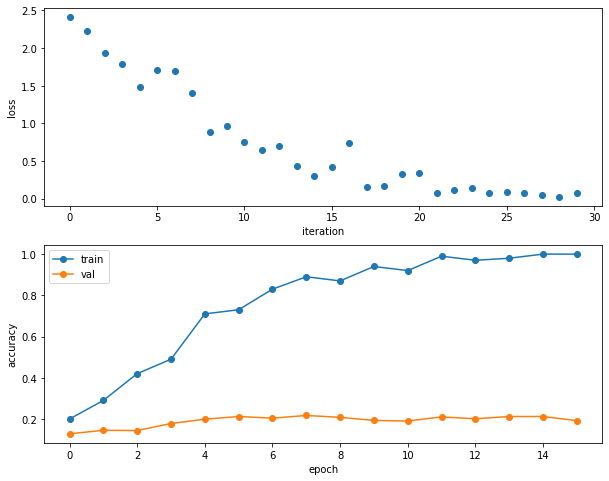

In [22]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 训练网络
通过对三层卷积网络进行1个epoch的训练，训练集的准确率应达到40%以上:

In [23]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304740
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.112254
(Iteration 41 / 980) loss: 1.839801
(Iteration 61 / 980) loss: 1.654228
(Iteration 81 / 980) loss: 1.710945
(Iteration 101 / 980) loss: 1.712855
(Iteration 121 / 980) loss: 1.598298
(Iteration 141 / 980) loss: 1.689535
(Iteration 161 / 980) loss: 1.683083
(Iteration 181 / 980) loss: 1.606298
(Iteration 201 / 980) loss: 1.914768
(Iteration 221 / 980) loss: 1.693683
(Iteration 241 / 980) loss: 1.484315
(Iteration 261 / 980) loss: 1.474231
(Iteration 281 / 980) loss: 1.592995
(Iteration 301 / 980) loss: 1.400443
(Iteration 321 / 980) loss: 1.547121
(Iteration 341 / 980) loss: 1.421683
(Iteration 361 / 980) loss: 1.577219
(Iteration 381 / 980) loss: 1.195093
(Iteration 401 / 980) loss: 1.530069
(Iteration 421 / 980) loss: 1.245582
(Iteration 441 / 980) loss: 1.456997
(Iteration 461 / 980) loss: 1.585542
(Iteration 481 / 980) loss: 1.296335
(Iteration 501 / 980) loss: 

## 可视化过滤器
你可以从训练好的网络中可视化第一层卷积滤波器，方法如下:

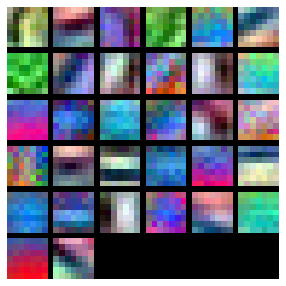

In [24]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# 空间批处理标准化
我们已经看到，批处理规范化对于训练深度全连接网络是一种非常有用的技术。批处理标准化也可以用于卷积网络，但是我们需要稍微调整一下;修改将被称为“空间批处理规范化”。

通常，批处理规范化接受shape`(N, D)`的输入，并生成shape`(N, D)`的输出，其中我们对整个minibatch维`N`进行规范化。对于来自卷积层的数据，批处理归一化需要接收shape`(N, C, H, W)`的输入，生成shape`(N, C, H, W)`的输出，其中`N`维给出的是minibatch size,`(H, W)`维给出的是feature map的空间大小。

如果feature map是使用convolutions来生成的，那么我们希望每个feature channel的统计在不同的image之间，以及在同一image内的不同位置上，是相对一致的。因此，空间批处理标准化通过计算minibatch维度`N`和空间维度`H`和`W`上的统计信息来计算每个`C`特征通道的平均值和方差。

## 空间批处理规范化:前向
在文件`cs231n/layers`中。在函数`spatial_batchnorm_forward`中实现空间批处理规范化的前向传递。检查你的实现运行以下:

In [25]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [26]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


## 空间批处理规范化:后向
在文件`cs231n/layers`中在函数`spatial_batchnorm_back`中实现空间批处理规范化的后向遍历。运行以下程序来检查你的实现使用数值梯度检查:

In [27]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648197756335e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


# 额外信用描述
如果您为了获得额外的学分而实现了任何其他特性，请在这里用指向此文件或其他文件(如果适用)中的任何代码的指针清楚地描述它们。